In [237]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
from pyfaidx import Fasta
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [238]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [239]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [293]:
p_df = pd.read_csv(proc_cfg(config['lr']['poder_protein']['protein']['summary'], od), sep='\t')
p_df = p_df.merge(mt_df[['associated_gene_biotype', 'structural_category', 'isoform', 'associated_gene']],
                  how='left',
                  left_on='tid', 
                  right_on='isoform')
p_df.rename({'associated_gene':'gid',
             'protein_sequence':'seq'}, axis=1, inplace=True)
assert len(p_df.loc[p_df.isoform.isnull()]) == 0

## First, need to filter

In [294]:
# remove NMD things
p_df = p_df.loc[p_df.protein_is_nmd == False]

# keep only things w/ full ORFs
p_df = p_df.loc[(p_df.protein_has_start_codon==True)&\
                (p_df.protein_has_stop_codon==True)]

# keep only things from annotated protein coding genes
p_df = p_df.loc[p_df.associated_gene_biotype=='Protein Coding']

# length minimum?? maybe not
print(len(p_df.index))

86332


In [295]:
# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs = ref_orfs[['seq', 'gid']]
ref_orfs['annot_aa'] = True
ref_orfs.drop_duplicates(inplace=True)

# just going to call novel aas as those that are not in the 
# pc translations gencode file
print(len(p_df))
p_df = p_df.merge(ref_orfs, how='left', on=['gid', 'seq'])
print(len(p_df))
p_df['annot_aa'] = p_df['annot_aa'].fillna(False)
p_df.head()

86332
86332


,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,pid,...,protein_splice_category,protein_splice_subcategory,protein_has_stop_codon,protein_has_start_codon,seq,associated_gene_biotype,structural_category,isoform,gid,annot_aa
0,chr12,4590319,4613888,+,ENSEMBL,ORFanage,4591180,4613750,ENST00000010132.6,ENSP00000010132.5,...,full-splice_match,multi-exon,True,True,MPASELKASEIPFHPSIKTQDPKAEEKSPKKQKVTLTAAEALKLFK...,Protein Coding,FSM,ENST00000010132.6,ENSG00000010219.14,True
1,chr12,7919229,7936187,-,HAVANA,ORFanage,7921415,7936034,ENST00000075120.12,ENSP00000516774.1,...,full-splice_match,multi-exon,True,True,MGTQKVTPALIFAITVATIGSFQFGYNTGVINAPEKIIKEFINKTL...,Protein Coding,FSM,ENST00000075120.12,ENSG00000059804.18,True
2,chrY,2935380,2982506,+,HAVANA,ORFanage,2953936,2979990,ENST00000155093.8,ENSP00000155093.3,...,full-splice_match,multi-exon,True,True,MDEDEFELQPQEPNSFFDGIGADATHMDGDQIVVEIQEAVFVSNIV...,Protein Coding,FSM,ENST00000155093.8,ENSG00000067646.12,True
3,chrX,48922210,48957631,-,HAVANA,ORFanage,48923176,48957570,ENST00000156084.8,ENSP00000156084.4,...,full-splice_match,multi-exon,True,True,MTILPKKKPPPPDADPANEPPPPGPMPPAPRRGGGVGVGGGGTGVG...,Protein Coding,FSM,ENST00000156084.8,ENSG00000068308.15,True
4,chr6,155395367,155455839,-,HAVANA,ORFanage,155396838,155455800,ENST00000159060.3,ENSP00000159060.2,...,full-splice_match,multi-exon,True,True,MMGCWILNEGLSTILVLSWLGINFYLFIDTFYWYEEEESFHYTRVI...,Protein Coding,FSM,ENST00000159060.3,ENSG00000074771.4,True


,annot_aa,n_tid
0,False,45931
1,True,40401


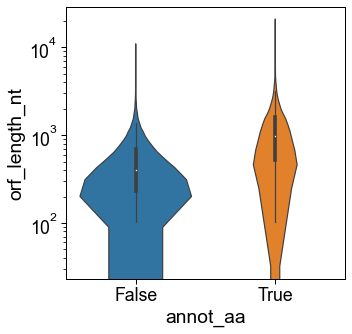

In [297]:
# lengths of gencode matches vs. not to pick length filter
init_plot_settings(aspect='square')
ax = sns.violinplot(p_df, y='orf_length_nt', x='annot_aa')
ax.set(yscale='log')

p_df[['annot_aa', 'tid']].groupby('annot_aa').nunique().reset_index().rename({'tid':'n_tid'}, axis=1)

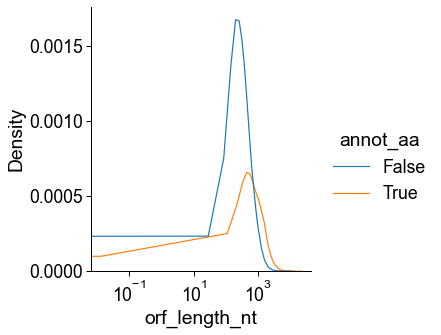

In [298]:
ax = sns.displot(p_df, x='orf_length_nt', hue='annot_aa',
            kind='kde',
            common_norm=False)
ax.set(xscale='log')

In [299]:
p_df[['orf_length_nt', 'annot_aa']].groupby('annot_aa').min()

,orf_length_nt
annot_aa,
False,102
True,102


In [245]:
p_df.head()

,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,pid,...,protein_splice_category,protein_splice_subcategory,protein_has_stop_codon,protein_has_start_codon,seq,associated_gene_biotype,structural_category,isoform,gid,perfect_blast_match
0,chr12,4590319,4613888,+,ENSEMBL,ORFanage,4591180,4613750,ENST00000010132.6,ENSP00000010132.5,...,full-splice_match,multi-exon,True,True,MPASELKASEIPFHPSIKTQDPKAEEKSPKKQKVTLTAAEALKLFK...,Protein Coding,FSM,ENST00000010132.6,ENSG00000010219.14,True
2,chr12,7919229,7936187,-,HAVANA,ORFanage,7921415,7936034,ENST00000075120.12,ENSP00000516774.1,...,full-splice_match,multi-exon,True,True,MGTQKVTPALIFAITVATIGSFQFGYNTGVINAPEKIIKEFINKTL...,Protein Coding,FSM,ENST00000075120.12,ENSG00000059804.18,True
3,chrY,2935380,2982506,+,HAVANA,ORFanage,2953936,2979990,ENST00000155093.8,ENSP00000155093.3,...,full-splice_match,multi-exon,True,True,MDEDEFELQPQEPNSFFDGIGADATHMDGDQIVVEIQEAVFVSNIV...,Protein Coding,FSM,ENST00000155093.8,ENSG00000067646.12,True
4,chrX,48922210,48957631,-,HAVANA,ORFanage,48923176,48957570,ENST00000156084.8,ENSP00000156084.4,...,full-splice_match,multi-exon,True,True,MTILPKKKPPPPDADPANEPPPPGPMPPAPRRGGGVGVGGGGTGVG...,Protein Coding,FSM,ENST00000156084.8,ENSG00000068308.15,True
5,chr6,155395367,155455839,-,HAVANA,ORFanage,155396838,155455800,ENST00000159060.3,ENSP00000159060.2,...,full-splice_match,multi-exon,True,True,MMGCWILNEGLSTILVLSWLGINFYLFIDTFYWYEEEESFHYTRVI...,Protein Coding,FSM,ENST00000159060.3,ENSG00000074771.4,True


## How many novel AA sequences do we add?

In [301]:
p_df['perfect_blast_match'] = p_df.blastp_identity==100
p_df[['perfect_blast_match', 'annot_aa', 'tid']].groupby(['annot_aa', 'perfect_blast_match']).nunique()

tid
annot_aa perfect_blast_match       
False    False                20938
         True                 24993
True     False                   65
         True                 40336

In [302]:
p_df['aa_id'] = p_df.gid+'_'+p_df.seq
p_df[['aa_id', 'annot_aa']].groupby('annot_aa').nunique().rename({'aa_id': 'n_aa_gid'}, axis=1)

,n_aa_gid
annot_aa,
False,39104
True,28073


In [303]:
# how many unique novel AAs do we add per gene?
temp = p_df[['seq', 'annot_aa', 'gid']].groupby(['gid', 'annot_aa']).nunique().reset_index().rename({'seq':'n_aa'}, axis=1)

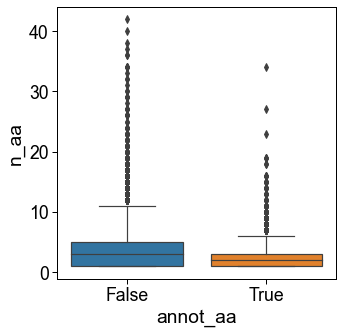

In [304]:
init_plot_settings(aspect='square')
ax = sns.boxplot(temp, y='n_aa', x='annot_aa')

In [305]:
# mean number of AAs per protein coding gene
temp[['n_aa', 'annot_aa']].groupby('annot_aa').mean()

,n_aa
annot_aa,
False,3.865560
True,2.175358


86332
67014


<AxesSubplot:ylabel='blastp_identity'>

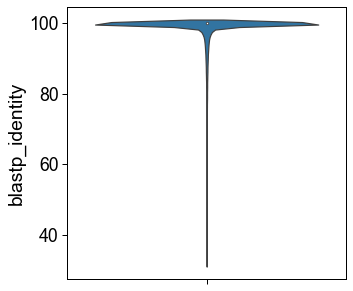

In [306]:
# for the uniq aas that we add that are new, what do the blast identities look like?
temp = p_df[['annot_aa', 'seq', 'blastp_identity']]
print(len(temp))
temp = temp.drop_duplicates()
print(len(temp))

sns.violinplot(temp, y='blastp_identity')

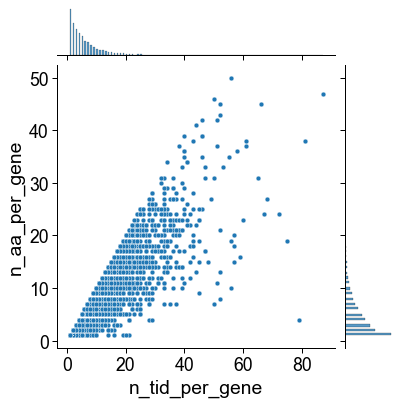

In [307]:
# unique transcripts vs. # unique transcripts per gene total (jointplot)

# transcripts / gene
p_df['n_tid_per_gene'] = p_df.groupby('gid')['tid'].transform('nunique')

# aa / gene
p_df['n_aa_per_gene'] = p_df.groupby('gid')['seq'].transform('nunique')

temp = p_df[['gid', 'n_tid_per_gene', 'n_aa_per_gene']].drop_duplicates()
sns.jointplot(temp, x='n_tid_per_gene', y='n_aa_per_gene')

## How many novel AA sequences do we add?

In [308]:
# how many total novel AAs do we add? how many do we detect? how many were already annotated?
# bar plot
p_df['aa_id'] = p_df.gid+'_'+p_df.seq
temp = p_df[['aa_id']].drop_duplicates()
temp['PODER'] = True

ref_orfs['aa_id'] = ref_orfs.gid+'_'+ref_orfs.seq
temp2 = ref_orfs[['aa_id']].drop_duplicates()
temp2['GENCODE v47'] = True

temp = temp.merge(temp2, 
                  how='outer',
                  on='aa_id')
temp.fillna(False, inplace=True)
temp.set_index(['GENCODE v47', 'PODER'], inplace=True)


# temp2 = temp.groupby(['annot_aa']).nunique().reset_index().rename({'aa_id':'n_aa'},axis=1)
# temp2['PODER'] = True

# ref_orfs['aa_id'] = ref_orfs.gid+'_'+ref_orfs.seq

# n = len(ref_orfs.aa_id.unique())
# temp = pd.DataFrame().from_dict({'annotation':['GENCODE v47'], 'n_aa':[n]})
# temp['GENCODE v47'] = True
# temp2 = pd.concat([temp, temp2], axis=0)
# temp2[['n_aa', 'GENCODE v47', 'PODER']]

# temp2.fillna(False, inplace=True)
# temp2.set_index(['GENCODE v47', 'PODER'], inplace=True)
# temp2 = temp2[['n_aa']]

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

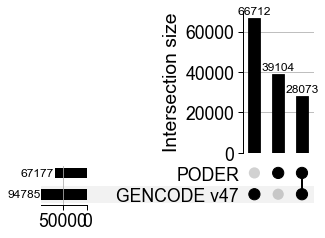

In [309]:
init_plot_settings(aspect='rectangle', font_scale=1)
plt.rcParams.update({'font.size': 12})
upsetplot.plot(temp, sort_by='cardinality', show_counts=True)


## What novelty categories are novel ORFs from generally? 

<AxesSubplot:xlabel='structural_category', ylabel='count'>

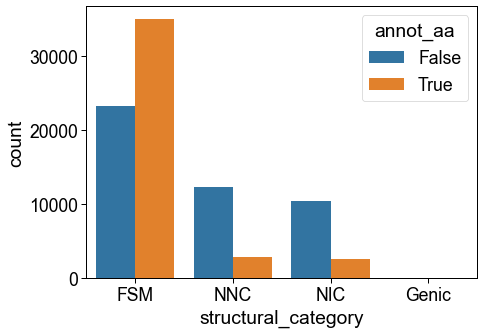

In [277]:
c_dict, order = get_novelty_colors()
temp = p_df[['tid',  'structural_category',
      'annot_aa']]
# .groupby(['structural_category', 'annot_aa']).nunique().rename({'tid':'n_t'}, axis=1).reset_index()

# g = sns.FacetGrid(temp, col='annot_aa')
# g.map(sns.countplot, x='structural_category', palette=c_dict, order=order)
sns.countplot(temp, hue='annot_aa', x='structural_category')

## Why are so many FSMs not matching? Did they have annotated AA sequences in the first place?

In [280]:
# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs['tid'] = ref_orfs.name.str.split('|', expand=True)[1]

In [282]:
# things w/o a perfect match in the annotation
# but that are FSMs
temp = p_df.loc[(p_df.annot_aa==False)&\
         (p_df.structural_category=='FSM')]
temp['tid_in_pc'] = temp.tid.isin(ref_orfs.tid.tolist())

temp[['tid', 'tid_in_pc']].groupby('tid_in_pc').nunique()

,tid
tid_in_pc,
False,22126
True,1110


In [ ]:
# ok, it's because they weren't there in the first place

## Number of unique AAs detected by population -- using my novelty classification

In [394]:
meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])
samples = [s for s in meta['sample'].tolist() if s in mt_df.columns]

temp = mt_df[['isoform']+samples]
temp.rename({'isoform': 'tid'}, axis=1, inplace=True)
temp.set_index('tid', inplace=True)
temp = temp.melt(ignore_index=False, var_name='sample', value_name='detected')

# remove undetected things
temp = temp.loc[temp.detected!=0]
temp.reset_index(inplace=True)

# merge in the gid_seq key and aa novelty status from p_df
temp = temp.merge(p_df[['annot_aa', 'tid', 'aa_id']],
                  how='inner', #limit to only the things we care about which are already in p_df
                  on='tid')

temp.drop(['detected', 'tid'], axis=1, inplace=True)
temp = temp.groupby(['annot_aa', 'sample']).nunique().rename({'aa_id':'n_aa'}, axis=1).reset_index()
temp['eur_noneur'] = 'Non-European'
temp.loc[(temp['sample'].str.startswith('AJI'))|\
         (temp['sample'].str.startswith('CEU')), 'eur_noneur'] = 'European'
temp.loc[temp.eur_noneur=='European']['sample'].unique()

array(['AJI1', 'AJI2', 'AJI3', 'AJI4', 'AJI5', 'AJI6', 'CEU1', 'CEU2',
       'CEU3', 'CEU4', 'CEU5'], dtype=object)

<AxesSubplot:xlabel='annot_aa', ylabel='n_aa'>

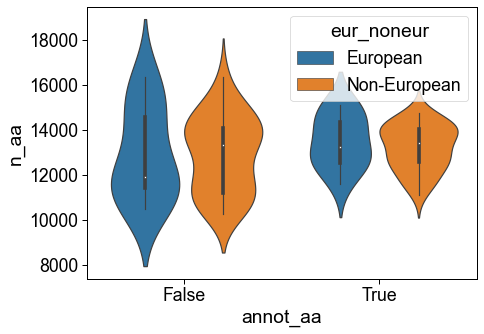

In [395]:
sns.violinplot(temp, y='n_aa', x='annot_aa', hue='eur_noneur')

## How do the sqanti novelty categories correspond to whether the protein was annotated in GENCODE?

In [352]:
print(len(p_df.index))
temp = p_df[['protein_splice_category', 'annot_aa', 'aa_id']].drop_duplicates()
print(len(temp.index))
print(len(p_df[['aa_id']].drop_duplicates()))
print(len(p_df[['annot_aa', 'aa_id']].drop_duplicates()))

86332
67219
67177
67177


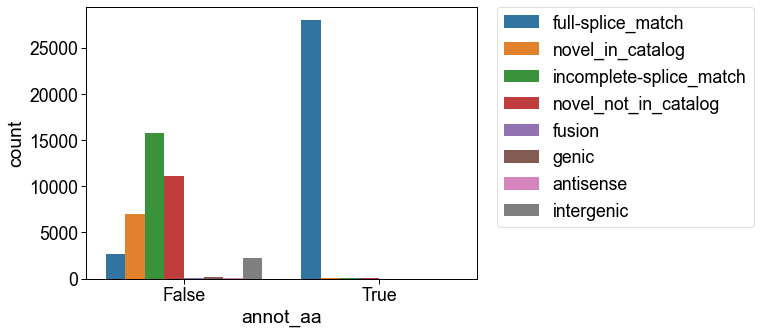

In [355]:
ax = sns.countplot(temp, x='annot_aa', hue='protein_splice_category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Do the same analyses for protein sequences detected in each populations buit using the novelty categories from SQANTI protein

In [412]:
meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])
samples = [s for s in meta['sample'].tolist() if s in mt_df.columns]

temp = mt_df[['isoform']+samples]
temp.rename({'isoform': 'tid'}, axis=1, inplace=True)
temp.set_index('tid', inplace=True)
temp = temp.melt(ignore_index=False, var_name='sample', value_name='detected')

# remove undetected things
temp = temp.loc[temp.detected!=0]
temp.reset_index(inplace=True)

# merge in the gid_seq key and aa novelty status from p_df
temp = temp.merge(p_df[['protein_splice_category', 'tid', 'aa_id', 'seq']],
                  how='inner', #limit to only the things we care about which are already in p_df
                  on='tid')


In [413]:
print(len(temp[['aa_id', 'protein_splice_category']].drop_duplicates()))
print(len(temp[['seq', 'protein_splice_category']].drop_duplicates()))

print(len(temp[['aa_id']].drop_duplicates()))      
print(len(temp[['seq']].drop_duplicates()))      

67219
66970
67177
66916


In [414]:

temp.drop(['detected', 'tid', 'aa_id'], axis=1, inplace=True)
temp.head()
temp = temp.groupby(['protein_splice_category', 'sample']).nunique().rename({'seq':'n_seq'}, axis=1).reset_index()
temp['eur_noneur'] = 'Non-European'
temp.loc[(temp['sample'].str.startswith('AJI'))|\
         (temp['sample'].str.startswith('CEU')), 'eur_noneur'] = 'European'
temp.loc[temp.eur_noneur=='European']['sample'].unique()

array(['AJI1', 'AJI2', 'AJI3', 'AJI4', 'AJI5', 'AJI6', 'CEU1', 'CEU2',
       'CEU3', 'CEU4', 'CEU5'], dtype=object)

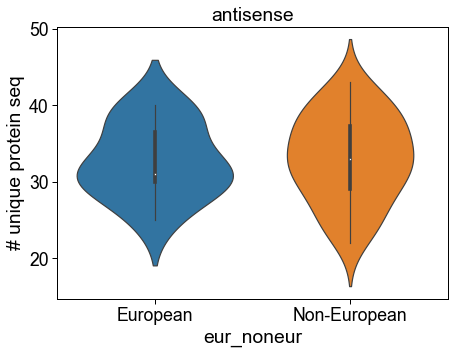

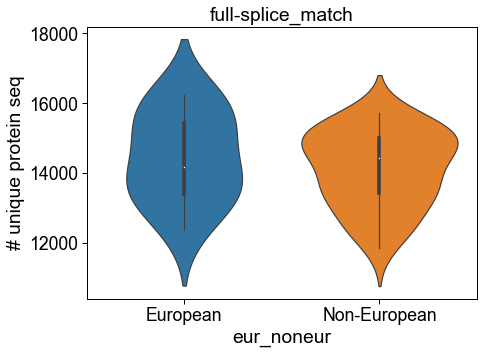

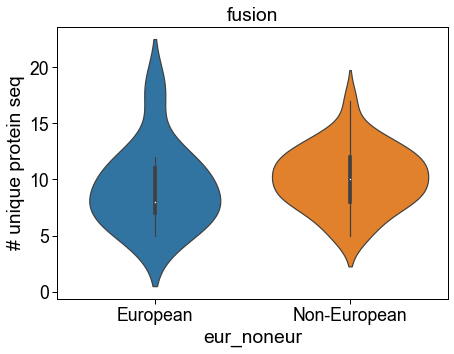

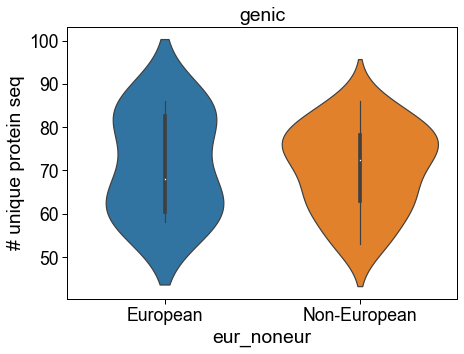

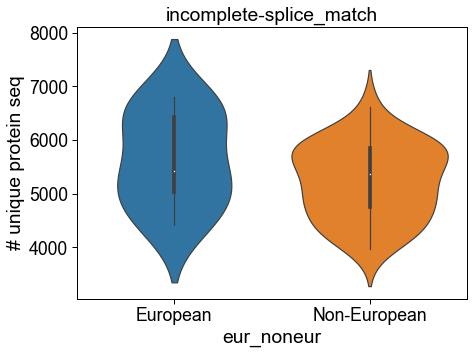

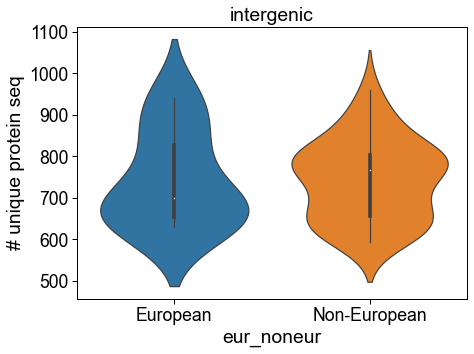

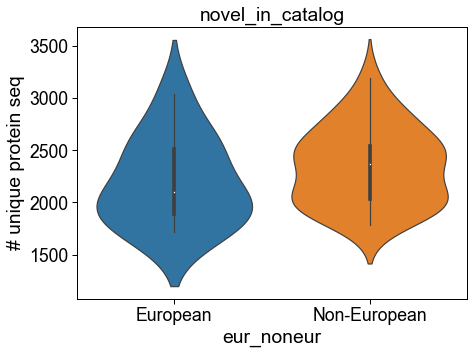

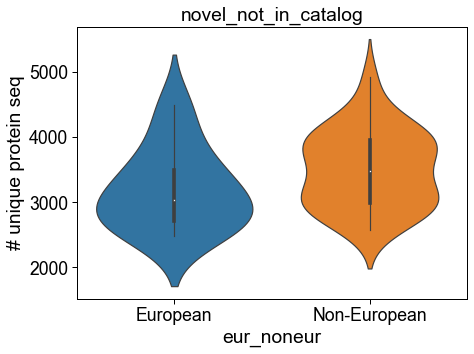

In [416]:
for c in temp.protein_splice_category.unique().tolist():
    temp2 = temp.loc[temp.protein_splice_category==c].copy(deep=True)
    ax = sns.violinplot(temp2, y='n_seq', x='eur_noneur')
    ax.set(title=c, ylabel='# unique protein seq')
    plt.show()